安装依赖库

In [3]:
# ! pip install -U datasets==1.6.2
# ! pip install transformers==4.27.4
# ! pip install --force-reinstall -U setuptools
# ! pip install --only-binary :all: rouge-score
# ! pip install -U jupyter ipywidgets

微调transformer模型解决摘要生成任务

在本notebook中，我们将展示如何微调 [🤗 Transformers](https://github.com/huggingface/transformers)中的预训练模型来解决摘要生成任务。我们使用[XSum dataset](https://arxiv.org/pdf/1808.08745.pdf)数据集。这个数据集包含了BBC的文章和一句对应的摘要。下面是一个例子：

![Widget inference on a summarization task](https://github.com/huggingface/notebooks/blob/master/examples/images/summarization.png?raw=1)

对于摘要生成任务，我们将展示如何使用简单的加载数据集，同时针对相应的仍无使用transformer中的Trainer接口对模型进行微调。

In [4]:
model_checkpoint = "t5-small"

只要预训练的transformer模型包含seq2seq结构的head层，那么本notebook理论上可以使用各种各样的transformer模型，解决任何摘要生成任务。这里，我们使用[`t5-small`](https://huggingface.co/t5-small)模型checkpoint。


## 加载数据

我们将会使用[🤗 Datasets](https://github.com/huggingface/datasets)库来加载数据和对应的评测方式。数据加载和评测方式加载只需要简单使用load_dataset和load_metric即可。
由于无法访问huggingface，这里都采用从本地load的方式

In [60]:
from datasets import load_from_disk, load_metric

raw_datasets = load_from_disk("xsum")
metric = load_metric("rouge.py")

这个datasets对象本身是一种[`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict)数据结构. 对于训练集、验证集和测试集，只需要使用对应的key（train，validation，test）即可得到相应的数据。

In [6]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

给定一个数据切分的key（train、validation或者test）和下标即可查看数据：

In [9]:
raw_datasets["train"][0]

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

为了能够进一步理解数据长什么样子，下面的函数将从数据集里随机选择几个例子进行展示。

In [8]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=2):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(raw_datasets["train"])

,document,summary,id
0,"The Kinghorn lifeboat crew were alerted after receiving a mobile phone call from one of the men aboard the 10ft (3m) tender dinghy.\nThey were found east of the island of Inchkeith, near the main shipping channel, following a search.\nThe RNLI said the two men were cold but uninjured after the incident on Saturday afternoon.",Two men have been rescued by lifeboat after their dinghy's engine failed in the Firth of Forth.,36182218
1,"Manager Chris Coleman says Bale could face Sweden but dismissed injury fears.\nThe 26-year-old suffered with cramp late on in Real's win over Atletico Madrid.\n""We'll see how the trip to Stockholm is physically and mentally before we decide whether he starts or comes on,"" he said.\nColeman continued: ""In the Champions League he went down with a bit of cramp and we were going 'oh here we go' but thankfully he was OK.\n""We haven't had Gareth since the Andorra game [in October] which seems like a long time now.""\nBale nor Arsenal midfielder Aaron Ramsey took part in in full training on Wednesday.\nJoe Ledley, Joe Allen and Hal Robson-Kanu all have injuries and did not take part in full training although midfielders Ledley and Allen trained on their own.\nThe trio will miss Sunday's friendly againts Sweden in Stockholm, with Emyr Huws and Wes Burns now travelling to France to provide cover to the trio.\nColeman is monitoring midfielders Ledley, who suffered a fractured leg in Crystal Palace's 2-1 win against Stoke City on 7 May, and Allen as well as forward Robson-Kanu with the trio now fighting to be fit for Wales' opening game against Slovakia on 11 June.\nWales also face England on 16 June and Russia on 20 June in their Group B fixtures.\n""If we needed to really push the players we could, but we don't need to do that,"" Coleman told BBC Wales Sport.\n""Hal and Joe won't play in Sweden. We know what we are getting prepared for. The injured players' rehab will be lined up to get them training with us the week leading up to Slovakia.""\nColeman, who recently signed a new deal to stay as Wales boss, says Ledley is ahead of schedule in terms of his rehabilitation after including him in his 23 man squad and even thinks he could be fit for Wales' opening game.\n""At the moment he is looking very good,"" Coleman added, ""He's a little bit further ahead than where we expected and physically he is looking fantastic, probably the best I have seen him.\n""It is a credit to Joe that he is ahead of the curve for this type of injury.\n""We have between now and Slovakia and let's hope we see an improvement and he keeps going the way he has been going and he will be available for us.\n""It would be an incredible credit to him and the medical team for getting him ready.""",Gareth Bale has taken part his first training session with Wales since winning the Champions League for a second time with Real Madrid.,36422806


metric是[`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric)类的一个实例，查看metric和使用的例子:

In [10]:
metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each predictions
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_agregator: Return aggregates if this is set to True
Retu

我们使用`compute`方法来对比predictions和labels，从而计算得分。predictions和labels都需要是一个list。具体格式见下面的例子：

In [11]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

## 数据预处理

在将数据喂入模型之前，我们需要对数据进行预处理。预处理的工具叫Tokenizer。Tokenizer首先对输入进行tokenize，然后将tokens转化为预模型中需要对应的token ID，再转化为模型需要的输入格式。

为了达到数据预处理的目的，我们使用AutoTokenizer.from_pretrained方法实例化我们的tokenizer，这样可以确保：

- 我们得到一个与预训练模型一一对应的tokenizer。
- 使用指定的模型checkpoint对应的tokenizer的时候，我们也下载了模型需要的词表库vocabulary，准确来说是tokens vocabulary。


这个被下载的tokens vocabulary会被缓存起来，从而再次使用的时候不会重新下载。

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, local_files_only=True)

By default, the call above will use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library.

tokenizer既可以对单个文本进行预处理，也可以对一对文本进行预处理，tokenizer预处理后得到的数据满足预训练模型输入格式

In [13]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

上面看到的token IDs也就是input_ids一般来说随着预训练模型名字的不同而有所不同。原因是不同的预训练模型在预训练的时候设定了不同的规则。但只要tokenizer和model的名字一致，那么tokenizer预处理的输入格式就会满足model需求的。关于预处理更多内容参考[这个教程](https://huggingface.co/transformers/preprocessing.html)

除了可以tokenize一句话，我们也可以tokenize一个list的句子。

In [10]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

注意：为了给模型准备好翻译的targets，我们使用`as_target_tokenizer`来控制targets所对应的特殊token：

In [15]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


/home/lixy/.conda/envs/tslib/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


如果您使用的是T5预训练模型的checkpoints，需要对特殊的前缀进行检查。T5使用特殊的前缀来告诉模型具体要做的任务，具体前缀例子如下：


In [61]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

现在我们可以把所有内容放在一起组成我们的预处理函数了。我们对样本进行预处理的时候，我们还会`truncation=True`这个参数来确保我们超长的句子被截断。默认情况下，对与比较短的句子我们会自动padding。

In [12]:
max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

以上的预处理函数可以处理一个样本，也可以处理多个样本exapmles。如果是处理多个样本，则返回的是多个样本被预处理之后的结果list。

In [18]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[21603, 10, 37, 423, 583, 13, 1783, 16, 20126, 16496, 6, 80, 13, 8, 844, 6025, 4161, 6, 19, 341, 271, 14841, 5, 7057, 161, 19, 4912, 16, 1626, 5981, 11, 186, 7540, 16, 1276, 15, 2296, 7, 5718, 2367, 14621, 4161, 57, 4125, 387, 5, 15059, 7, 30, 8, 4653, 4939, 711, 747, 522, 17879, 788, 12, 1783, 44, 8, 15763, 6029, 1813, 9, 7472, 5, 1404, 1623, 11, 5699, 277, 130, 4161, 57, 18368, 16, 20126, 16496, 227, 8, 2473, 5895, 15, 147, 89, 22411, 139, 8, 1511, 5, 1485, 3271, 3, 21926, 9, 472, 19623, 5251, 8, 616, 12, 15614, 8, 1783, 5, 37, 13818, 10564, 15, 26, 3, 9, 3, 19513, 1481, 6, 18368, 186, 1328, 2605, 30, 7488, 1887, 3, 18, 8, 711, 2309, 9517, 89, 355, 5, 3966, 1954, 9233, 15, 6, 113, 293, 7, 8, 16548, 13363, 106, 14022, 84, 47, 14621, 4161, 6, 243, 255, 228, 59, 7828, 8, 1249, 18, 545, 11298, 1773, 728, 8, 8347, 1560, 5, 611, 6, 255, 243, 72, 1709, 1528, 161, 228, 43, 118, 4006, 91, 12, 766, 8, 3, 19513, 1481, 410, 59, 5124, 5, 96, 196, 17, 19, 1256, 68, 27, 103, 317, 132

接下来对数据集datasets里面的所有样本进行预处理，处理的方式是使用map函数，将预处理函数prepare_train_features应用到（map)所有样本上。

In [13]:
cache_file_names = {
    "train": "cache/xsum_train.arrow",
    "validation": "cache/xsum_validation.arrow",
    "test": "cache/xsum_test.arrow"
}
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True, cache_file_names=cache_file_names)

Loading cached processed dataset at cache/xsum_train.arrow


/home/lixy/.conda/envs/tslib/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3586: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


更好的是，返回的结果会自动被缓存，避免下次处理的时候重新计算（但是也要注意，如果输入有改动，可能会被缓存影响！）。datasets库函数会对输入的参数进行检测，判断是否有变化，如果没有变化就使用缓存数据，如果有变化就重新处理。但如果输入参数不变，想改变输入的时候，最好清理调这个缓存。清理的方式是使用`load_from_cache_file=False`参数。另外，上面使用到的`batched=True`这个参数是tokenizer的特点，以为这会使用多线程同时并行对输入进行处理。

## 微调模型

既然数据已经准备好了，现在我们需要下载并加载我们的预训练模型，然后微调预训练模型。既然我们是做seq2seq任务，那么我们需要一个能解决这个任务的模型类。我们使用`AutoModelForSeq2SeqLM`这个类。和tokenizer相似，`from_pretrained`方法同样可以帮助我们下载并加载模型，同时也会对模型进行缓存，就不会重复下载模型啦。

In [2]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

由于我们微调的任务是seq2seq任务，而我们加载的是预训练的seq2seq模型，所以不会提示我们加载模型的时候扔掉了一些不匹配的神经网络参数（比如：预训练语言模型的神经网络head被扔掉了，同时随机初始化了机器翻译的神经网络head）。


为了能够得到一个`Seq2SeqTrainer`训练工具，我们还需要3个要素，其中最重要的是训练的设定/参数[`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments)。这个训练设定包含了能够定义训练过程的所有属性。在训练过程中每500步进行一次验证，并保存rougeL指标最优的模型

In [20]:
batch_size = 8
args = Seq2SeqTrainingArguments(
    "test-summarization",
    evaluation_strategy="steps", 
    load_best_model_at_end=True,
    metric_for_best_model='rougeL',
    greater_is_better=True,
    eval_steps=500,
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
)

上面batch_size在这个notebook之前定义好了。

由于我们的数据集比较大，同时`Seq2SeqTrainer`会不断保存模型，所以我们需要告诉它至多保存`save_total_limit=3`个模型。

最后我们需要一个数据收集器data collator，将我们处理好的输入喂给模型。

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

设置好`Seq2SeqTrainer`还剩最后一件事情，那就是我们需要定义好评估方法。我们使用`metric`来完成评估。将模型预测送入评估之前，我们也会做一些数据后处理：

In [12]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

最后将所有的参数/数据/模型传给`Seq2SeqTrainer`即可

In [21]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

调用`train`方法进行微调训练。

In [ ]:
trainer.train()

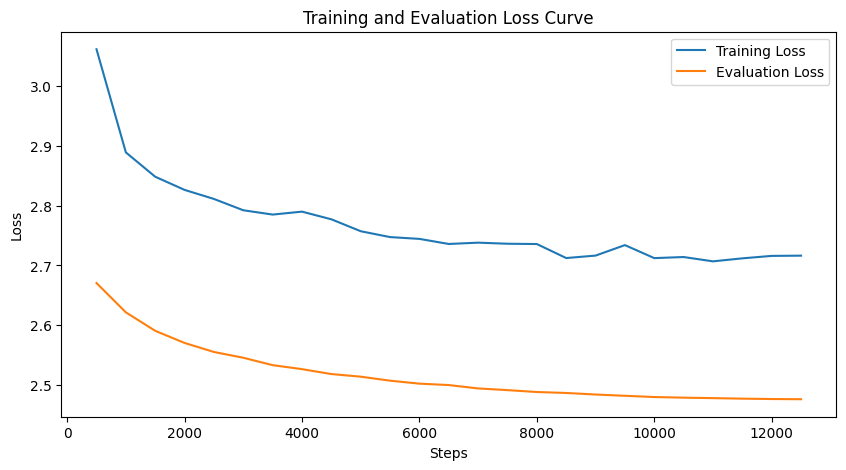

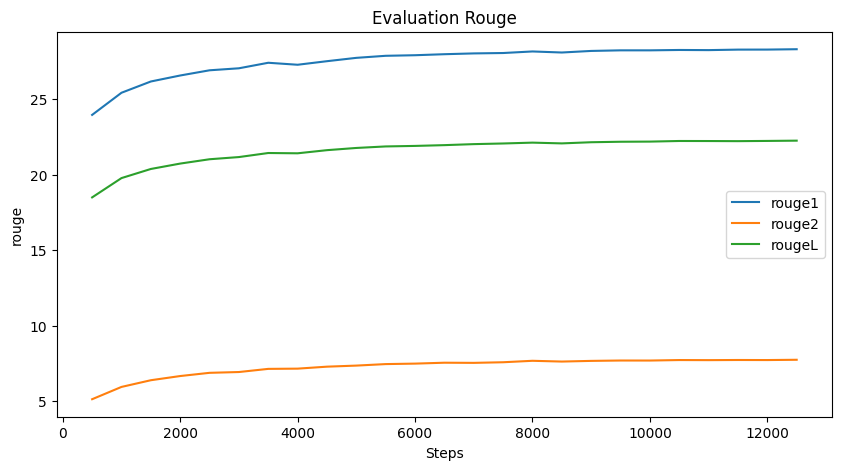

In [24]:
import json
import matplotlib.pyplot as plt

# Load the metrics
with open("test-summarization/checkpoint-12500/trainer_state.json", "r") as f:
    log_history = json.load(f)['log_history']

# Extract the loss and step data
train_loss = []
eval_loss = []
steps = []
metrics_name = ['rouge1','rouge2','rougeL']
metrics = dict(zip(metrics_name,[[] for _ in range(len(metrics_name))]))
for i in range(0,len(log_history),2):
    steps.append(log_history[i]['step'])
    train_loss.append(log_history[i]['loss'])
    eval_loss.append(log_history[i+1]['eval_loss'])
    for metric in metrics_name:
        metrics[metric].append(log_history[i+1]['eval_{}'.format(metric)])
# Plot the training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(train_loss)], train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Curve")
plt.legend()
plt.show()
#Plot the metrics
plt.figure(figsize=(10, 5))
for metric in metrics_name:
    plt.plot(steps[:len(train_loss)], metrics[metric], label=metric)
plt.xlabel("Steps")
plt.ylabel("rouge")
plt.title("Evaluation Rouge")
plt.legend()
plt.show()

加载微调好的模型进行验证

In [29]:
import torch
model = AutoModelForSeq2SeqLM.from_pretrained('test-summarization/checkpoint-12500')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [79]:
from torch.utils.data import DataLoader
from tqdm import tqdm
# First, let's create a proper data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
    max_length=max_input_length,
    return_tensors="pt"  # Explicitly specify return tensors type
)

# Create a custom Dataset class that only includes the fields we need
class SummarizationDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long)
        }

# Create dataset and dataloader
dataset = SummarizationDataset(tokenized_datasets['test'])
dataloader = DataLoader(
    dataset,
    batch_size=64,
    collate_fn=data_collator,
    shuffle=False
)

# Generate text
model.eval()
generated_texts = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_target_length
        )
        generated_texts.extend([tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids])

  0%|          | 0/178 [00:00<?, ?it/s]/home/lixy/.conda/envs/tslib/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2364: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 178/178 [04:19<00:00,  1.46s/it]


In [83]:
metric.compute(predictions=generated_texts, references=raw_datasets['test']['summary'])

{'rouge1': AggregateScore(low=Score(precision=0.31232948771484204, recall=0.2690275355497686, fmeasure=0.2834320523481787), mid=Score(precision=0.31481997081290614, recall=0.2710611470666031, fmeasure=0.2854307922268188), high=Score(precision=0.3173454420786995, recall=0.2733759377435099, fmeasure=0.2876718189730161)),
 'rouge2': AggregateScore(low=Score(precision=0.08622164199476093, recall=0.07408022924803576, fmeasure=0.07800210128701215), mid=Score(precision=0.08819892165251991, recall=0.07579994256858841, fmeasure=0.07978668929975333), high=Score(precision=0.08987357438677301, recall=0.07734302658893802, fmeasure=0.08131321844532895)),
 'rougeL': AggregateScore(low=Score(precision=0.2420381290480279, recall=0.2091223284576014, fmeasure=0.21996844787474812), mid=Score(precision=0.2443725248777212, recall=0.21109285528885757, fmeasure=0.22189762473946584), high=Score(precision=0.2465838228468575, recall=0.21298472441290847, fmeasure=0.22375710675398036)),
 'rougeLsum': AggregateScor